# Problem Statement
## Context
Some banking institutions use marketing campaigns to make clients subscribe to their services. One of those services is the term deposit, which restricts withdrawing the deposit until the term ends. This deposit allows a higher flexibility in budget management because it doesn't affect the "liquidity coverage ratio" (the amount of money that the bank has to be able to pay instantly). In this project marketing segmentation will be done.

## Goal
The goal is to divide all clients into distinct market segments by answering the following questions:
* By which distinct features each segment can be characterized?
* What type of customers marketing team should focus on for their next marketing campaign?

# Data Exploration
## Data Source
I used "Bank Marketing" dataset from Kaggle provided by user Henrique Yamahata. [https://www.kaggle.com/henriqueyamahata/bank-marketing?select=bank-additional-full.csv]

## Data description

In [1]:
#Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import OneHotEncoder
from kmodes.kmodes import KModes

# for interactive visualizations
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected = True)
import plotly.figure_factory as ff

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disabling autoscrolling for long graphs*/

<IPython.core.display.Javascript object>

In [3]:
data = pd.read_csv('bank-additional-full.csv', sep = ';')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Attributes can be divided into the following groups:

### Client data:
* Age (numeric)
* Job : type of job (categorical: 'admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
* Marital : marital status (categorical: 'divorced', 'married', 'single', 'unknown' ; note: 'divorced' means divorced or widowed)
* Education (categorical: 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown')
* Default: has credit in default? (categorical: 'no', 'yes', 'unknown')
* Housing: has housing loan? (categorical: 'no', 'yes', 'unknown')
* Loan: has personal loan? (categorical: 'no', 'yes', 'unknown')

### Current campaign
* Contact: last contact communication type (categorical: 'cellular','telephone')
* Month: last contact month of year (categorical: 'jan', 'feb', 'mar',…, 'nov', 'dec')
* Dayofweek: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* Duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no').
* Campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

### Previous campaign 
* Pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* Previous: number of contacts performed before this campaign and for this client (numeric)
* Poutcome: outcome of the previous marketing campaign (categorical:'failure','nonexistent','success')

### Social and economic context attributes
* Emp.var.rate: employment variation rate - quarterly indicator (numeric)
* Cons.price.idx: consumer price index - monthly indicator (numeric)
* Cons.conf.idx: consumer confidence index - monthly indicator(numeric)
* Euribor3m: euribor 3 month rate - daily indicator (numeric)
* Nr.employed: number of employees - quarterly indicator (numeric)

### Output variable
* y - has the client subscribed a term deposit? (binary: 'yes', 'no')

## Data preparation
### Missing values


In [4]:
print('Percentage of missing values by column: \n', data.replace('unknown', np.nan).isna().sum()/data.count() *100)

Percentage of missing values by column: 
 age                0.000000
job                0.801204
marital            0.194231
education          4.202680
default           20.872584
housing            2.403613
loan               2.403613
contact            0.000000
month              0.000000
day_of_week        0.000000
duration           0.000000
campaign           0.000000
pdays              0.000000
previous           0.000000
poutcome           0.000000
emp.var.rate       0.000000
cons.price.idx     0.000000
cons.conf.idx      0.000000
euribor3m          0.000000
nr.employed        0.000000
y                  0.000000
dtype: float64


Column 'default' has the most percentage of missing values, but generally all clients don't have default (only 3 clients have), so we can drop this column because it doesn't convey useful information.

### Preprocessing pipeline
At this step, I will create preprocessing pipeline for all variables. I will also remove 'duration' column because we can't get the value before getting the 'y' value.

In [5]:
data = data.replace('unknown', np.nan)
data.dropna(inplace = True)

columns_to_delete = ['age', 'previous', 'default','contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

X = data.drop(columns_to_delete, axis = 1)

binary_cols = [cname for cname in X.columns if (X[cname].dtype == "object") & (X[cname].nunique() == 2)]
categorical_cols = [cname for cname in X.columns if (X[cname].dtype == "object") & (X[cname].nunique() > 2)]

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

# since column names were deleted, I have to put them back using the function
def preprocess_data(X):
    results = pd.DataFrame.sparse.from_spmatrix(preprocessor.fit_transform(X))
    for cname in binary_cols: results[cname] = X.reset_index()[cname].map(dict(yes=1, no=0))
    OH_enc = OneHotEncoder()
    encoded_cols = list(OH_enc.fit(X[categorical_cols]).get_feature_names()) + binary_cols
    results.columns = encoded_cols
    return results

In [6]:
preprocessed_X = preprocess_data(X)
preprocessed_X

,x0_admin.,x0_blue-collar,x0_entrepreneur,x0_housemaid,x0_management,x0_retired,x0_self-employed,x0_services,x0_student,x0_technician,...,x2_high.school,x2_illiterate,x2_professional.course,x2_university.degree,x3_failure,x3_nonexistent,x3_success,housing,loan,y
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30483,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,0,1
30484,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,0
30485,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,0,0
30486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0,1


# Model building
I will use Kmeans as a baseline to check if we can get valuable information out of it.

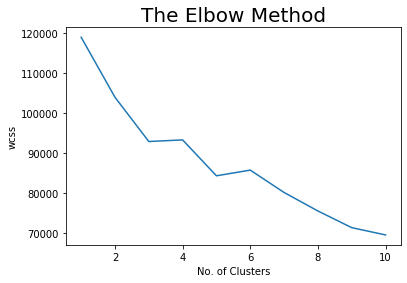

In [7]:
# Using elbow method to choose number of clusters
wcss = []
for i in range(1, 11):
    km = KModes(n_clusters=i, init='Cao', n_init=5, random_state = 0)
    km.fit(preprocessed_X)
    wcss.append(km.cost_)
    
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method', fontsize = 20)
plt.xlabel('No. of Clusters')
plt.ylabel('wcss')
plt.show()

It looks like 3 clusters is a good number.

In [8]:
# create and train the model
km = KModes(n_clusters=3, init='Cao', n_init=5, random_state = 0)
km.fit(preprocessed_X)
preprocessed_X['cluster'] = km.labels_

In [9]:
# checking number of entities in each cluster
preprocessed_X.groupby('cluster').count()

,x0_admin.,x0_blue-collar,x0_entrepreneur,x0_housemaid,x0_management,x0_retired,x0_self-employed,x0_services,x0_student,x0_technician,...,x2_high.school,x2_illiterate,x2_professional.course,x2_university.degree,x3_failure,x3_nonexistent,x3_success,housing,loan,y
cluster,,,,,,,,,,,,,,,,,,,,,
0,17492,17492,17492,17492,17492,17492,17492,17492,17492,17492,...,17492,17492,17492,17492,17492,17492,17492,17492,17492,17492
1,9443,9443,9443,9443,9443,9443,9443,9443,9443,9443,...,9443,9443,9443,9443,9443,9443,9443,9443,9443,9443
2,3553,3553,3553,3553,3553,3553,3553,3553,3553,3553,...,3553,3553,3553,3553,3553,3553,3553,3553,3553,3553


In [10]:
# checking efficiency of marketing campaign on each cluster
preprocessed_X.groupby('cluster')['y'].sum()/preprocessed_X.groupby('cluster')['y'].count()

cluster
0    0.117539
1    0.147517
2    0.115395
Name: y, dtype: float64

Now let's make a pairplot to see correlations between clusters and variables. To make visualizations easier to comprehend, I will use ordinal encoder.

In [11]:
categorical_cols = [cname for cname in X.columns if X[cname].dtype == "object"]

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('ordinal', OrdinalEncoder())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols)
    ])

# since column names were deleted, I have to put them back using the function
def visualize_data(X):
    results = pd.DataFrame(preprocessor.fit_transform(X))
    results.columns = categorical_cols
    return results

In [12]:
visualized_X = visualize_data(X)
visualized_X['age'] = data.reset_index()['age']
visualized_X

,job,marital,education,housing,loan,poutcome,y,age
0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,56
1,7.0,1.0,3.0,1.0,0.0,1.0,0.0,37
2,0.0,1.0,1.0,0.0,0.0,1.0,0.0,40
3,7.0,1.0,3.0,0.0,1.0,1.0,0.0,56
4,0.0,1.0,5.0,0.0,0.0,1.0,0.0,59
...,...,...,...,...,...,...,...,...
30483,5.0,1.0,5.0,1.0,0.0,1.0,1.0,73
30484,1.0,1.0,5.0,0.0,0.0,1.0,0.0,46
30485,5.0,1.0,6.0,1.0,0.0,1.0,0.0,56
30486,9.0,1.0,5.0,0.0,0.0,1.0,1.0,44


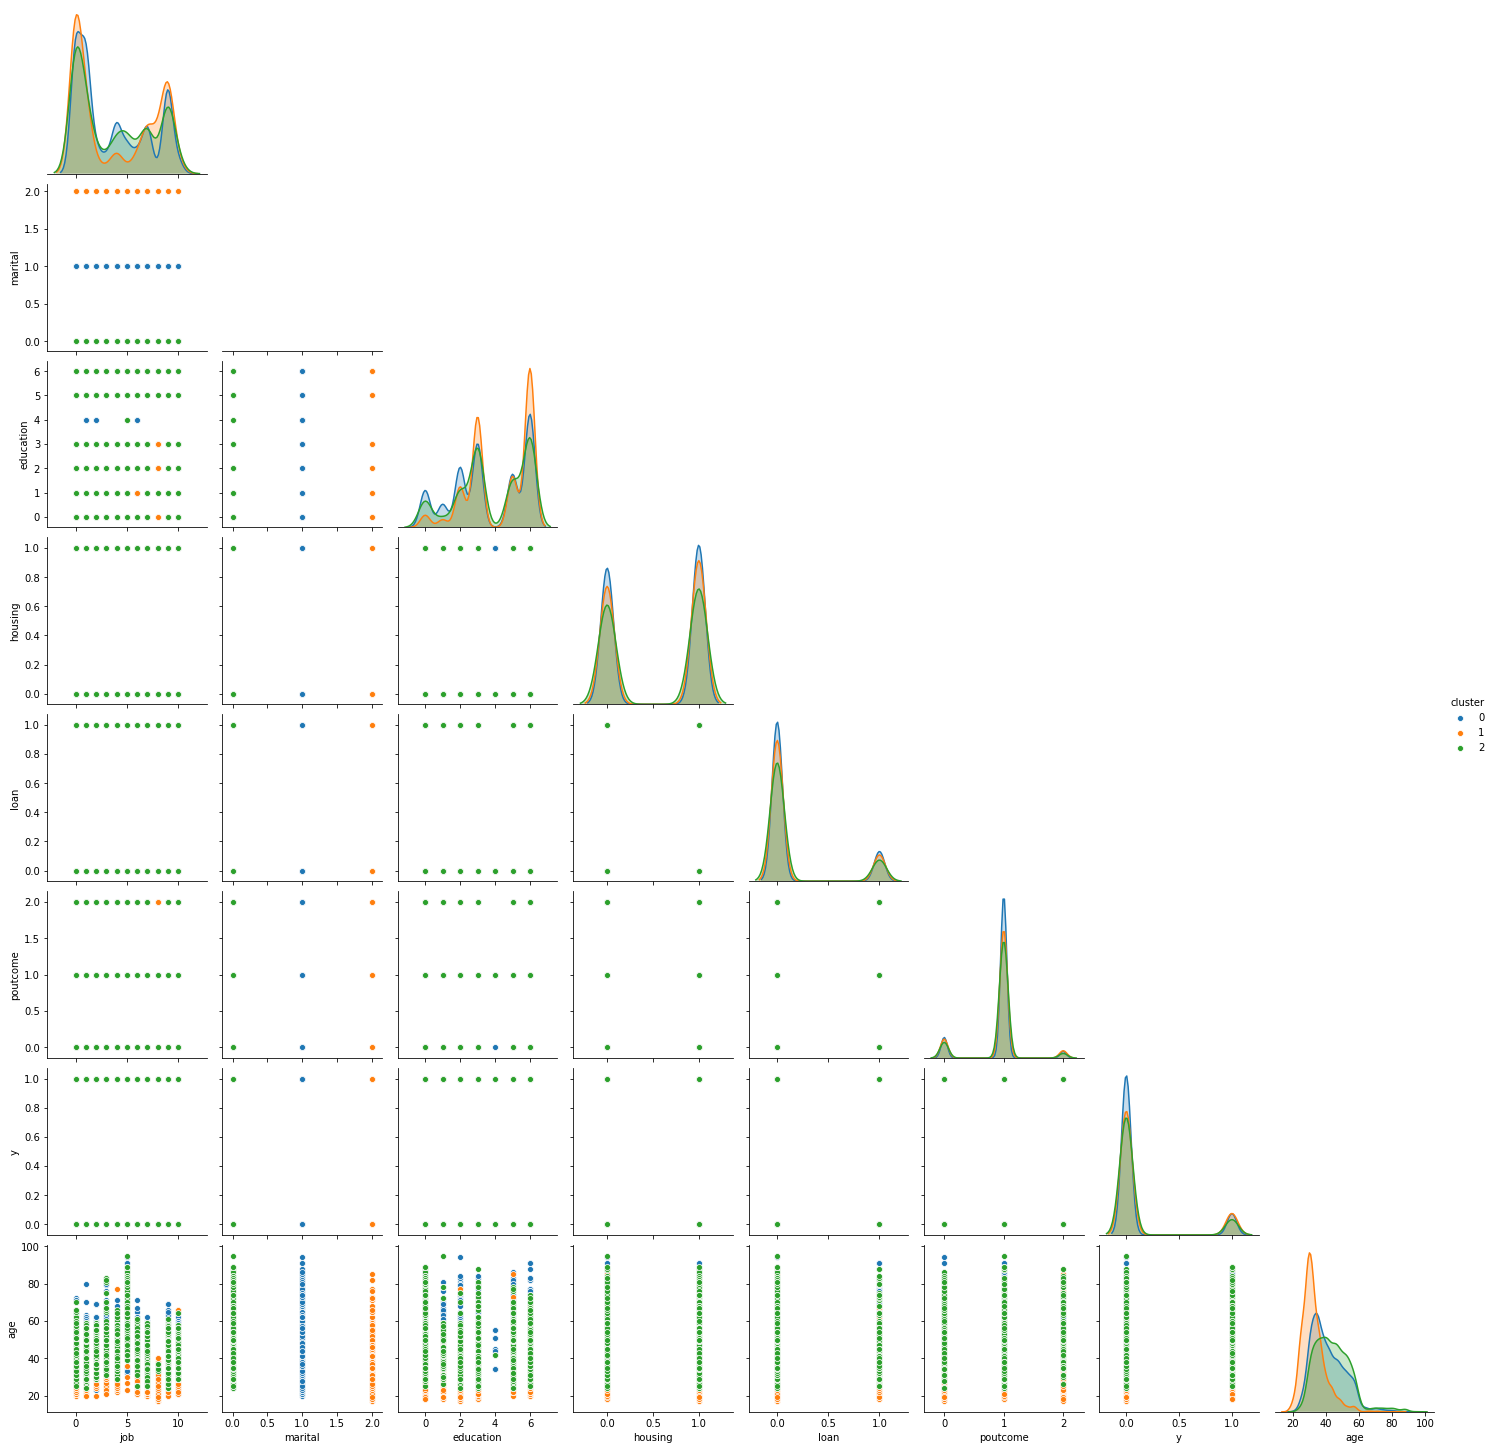

In [13]:
visualized_X['cluster'] = km.labels_
sns.distributions._has_statsmodels = False
sns.pairplot(visualized_X, hue = 'cluster', corner=True)

We can see some correlation in making clusters with 'job' and 'education' columns. Since 'age' is also demographically important variable, I will plot it too.

In [14]:
trace1 = go.Scatter3d(
    x= visualized_X['education'],
    y= visualized_X['marital'],
    z= visualized_X['age'],
    mode='markers',
     marker=dict(
        color = visualized_X['cluster'], 
        size= 10,
        opacity=0.8
     )
)
df = [trace1]

layout = go.Layout(
    title = 'Age vs Marital vs Education',
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0  
    ),
    scene = dict(
            xaxis = dict(title  = 'education'),
            yaxis = dict(title  = 'marital'),
            zaxis = dict(title  = 'age')
        )
)

fig = go.Figure(data = df, layout = layout)
py.iplot(fig)

In [15]:
# Decode ordinal encoding
for cname in X.columns:
    ord_enc = OrdinalEncoder()
    ord_enc.fit(X[cname].values.reshape(-1,1))
    print(cname)
    print(ord_enc.inverse_transform(np.asarray(range(X[cname].nunique())).reshape(-1,1)))

job
[['admin.']
 ['blue-collar']
 ['entrepreneur']
 ['housemaid']
 ['management']
 ['retired']
 ['self-employed']
 ['services']
 ['student']
 ['technician']
 ['unemployed']]
marital
[['divorced']
 ['married']
 ['single']]
education
[['basic.4y']
 ['basic.6y']
 ['basic.9y']
 ['high.school']
 ['illiterate']
 ['professional.course']
 ['university.degree']]
housing
[['no']
 ['yes']]
loan
[['no']
 ['yes']]
poutcome
[['failure']
 ['nonexistent']
 ['success']]
y
[['no']
 ['yes']]


Apparently, after multiple expirements, clustering algorithm decided that the best way to divide customers is based on their marital status. That makes sense, because singles, couples, and divorced may show different financial behavior.

In [16]:
# checking efficiency of previous marketing campaign on each cluster
visualized_X.loc[(visualized_X['poutcome'] == 2)].groupby('cluster')['y'].count()/visualized_X.groupby('cluster')['y'].count()

cluster
0    0.035788
1    0.047337
2    0.033211
Name: y, dtype: float64

In [17]:
# checking loyalty of each cluster
visualized_X.loc[(visualized_X['poutcome'] == 2) & (visualized_X['y'] == 1)].groupby('cluster')['y'].count()/visualized_X.groupby('cluster')['y'].count()

cluster
0    0.023382
1    0.029969
2    0.024486
Name: y, dtype: float64

We can see that even in terms of loyalty and efficiency of marketing campaigns married customers are more prefferable for targeting. Therefore, we can draw few conclusions.

# Conclusion
## Insights
* The best way to segment customers is based on their marital status. This clustering results in 3 segments of single, married and divorced with 9443, 17492 and 3553 customers respectively.
* Married clients are more willing to accept bank's marketing campaigns and have higher percentage of "loyal" customers based on the last 2 campaigns.
* Married clients constitute the biggest cluster.

## Produced value (recommended actions)
* Since married clients is the biggest cluster, has higher marketing campaign efficiency and loyalty, marketing team should target them as the most valuable segment of bank customers.
* In order to evaluate efficiency of the future marketing campaign that targets married customers, we should check whether mentioning cluster in the data improves predictions. If it does, then marketing team did a good job in focusing customers based on their marital status.